In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_hub as hub    
import tensorflow as tf
%matplotlib inline

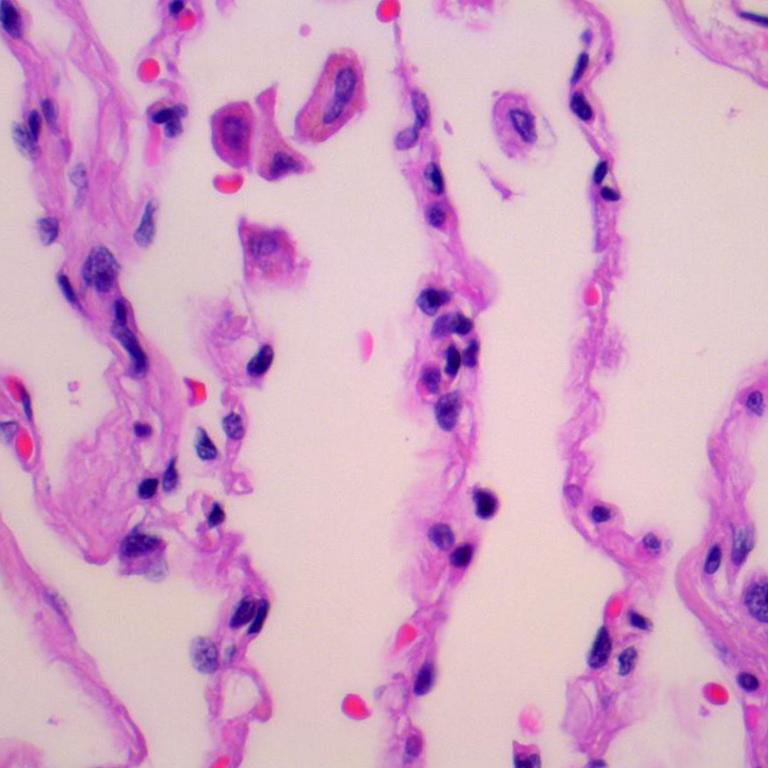

In [3]:
data_dir = 'D:/image_processing/Lung'
sample_img = os.path.join(data_dir, 'Benign/lungn1.jpeg')
img = Image.open(sample_img)
img

In [7]:
info_dict = {
    "Filename": img.filename,
    "Image Size": img.size,
    "Image Height": img.height,
    "Image Width": img.width,
    "Image Format": img.format,
    "Image Mode": img.mode,
    "Frames in Image": getattr(img, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : D:/image_processing/Lung\Benign/lungn1.jpeg
Image Size               : (768, 768)
Image Height             : 768
Image Width              : 768
Image Format             : JPEG
Image Mode               : RGB
Frames in Image          : 1


## Splitting to train, val, and test 

In [24]:
import splitfolders
input_folder = 'D:/image_processing/Lung/'
output_folder = 'D:/image_processing/Lung/after_split/'

In [13]:
# Split ratio (70, 20, 10)
splitfolders.ratio(input_folder, output=output_folder, seed=123, ratio=(0.7, 0.2, 0.1), group_prefix=None)

Copying files: 15000 files [00:11, 1278.72 files/s]


#### We have 10500, 3000, 1500 images for train, val, and test

## Augmenting

In [28]:
# We will be augmenting the train and val splits only
import Augmentor

p = Augmentor.Pipeline("D:/image_processing/Lung/after_split/train")

Initialised with 10500 image(s) found.
Output directory set to D:/image_processing/Lung/after_split/train\output.

In [29]:
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.6)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)
p.rotate_random_90(probability=0.5)
p.rotate180(probability=0.5)
p.sample(21000)

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x22074007550>: 100%|██████████| 21000/21000 [04:48<00:00, 72.74 Samples/s]                  


In [30]:
p2 = Augmentor.Pipeline("D:/image_processing/Lung/after_split/val")

Initialised with 3000 image(s) found.
Output directory set to D:/image_processing/Lung/after_split/val\output.

In [31]:
p2.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p2.zoom(probability=0.5, min_factor=1.1, max_factor=1.6)
p2.flip_left_right(probability=0.5)
p2.zoom_random(probability=0.5, percentage_area=0.8)
p2.flip_top_bottom(probability=0.5)
p2.rotate180(probability=0.5)
p2.sample(6000)

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x22073F06D90>: 100%|██████████| 6000/6000 [01:18<00:00, 76.22 Samples/s]                  


#### After Augmenting we have 21000, 6000, and 1500 for train, val, and test sets

## Pre-processing the images & Training the model

In [37]:
batch_size = 16
IMG_SHAPE = 299
base_dir = 'D:/image_processing/Lung/after_split'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [44]:
training_data = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           shuffle=True,
                                                           color_mode='rgb')

val_data = tf.keras.utils.image_dataset_from_directory(directory = val_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           label_mode='categorical',
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

Found 21000 files belonging to 3 classes.
Found 6000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [45]:
@tf.function
def map_fn(img, label):
    image_height = IMG_SHAPE
    image_width = IMG_SHAPE
    img = tf.image.resize(img, [image_height, image_width])
    img /= 255
    return img, label

trian = training_data.map(map_fn)
val = val_data.map(map_fn)
test = test_data.map(map_fn)

In [40]:
# inception_resnet_v2 model from tfhub

URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
  trainable=False)

with tf.device(device_name=device):
    
    model_inceptionres = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(3)
    ])

    model_inceptionres.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
_________________________________________________________________


In [41]:
with tf.device(device_name=device):
    
    model_inceptionres.compile(
      optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
      momentum=0.9),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

In [42]:
EPOCHS = 10
with tf.device(device_name=device):
    
    history = model_inceptionres.fit(trian,
                        epochs=EPOCHS,
                        validation_data=val)

Epoch 1/10
1313/1313 [==============================] - 505s 368ms/step - loss: 0.1658 - accuracy: 0.9352 - val_loss: 0.1313 - val_accuracy: 0.9500
Epoch 2/10
1313/1313 [==============================] - 487s 370ms/step - loss: 0.1243 - accuracy: 0.9526 - val_loss: 0.0958 - val_accuracy: 0.9595
Epoch 3/10
1313/1313 [==============================] - 489s 372ms/step - loss: 0.1061 - accuracy: 0.9582 - val_loss: 0.0836 - val_accuracy: 0.9665
Epoch 4/10
1313/1313 [==============================] - 487s 370ms/step - loss: 0.0970 - accuracy: 0.9630 - val_loss: 0.0892 - val_accuracy: 0.9653
Epoch 5/10
1313/1313 [==============================] - 487s 371ms/step - loss: 0.0911 - accuracy: 0.9659 - val_loss: 0.0815 - val_accuracy: 0.9660
Epoch 6/10
1313/1313 [==============================] - 488s 372ms/step - loss: 0.0744 - accuracy: 0.9714 - val_loss: 0.0723 - val_accuracy: 0.9690
Epoch 7/10
1313/1313 [==============================] - 492s 375ms/step - loss: 0.0722 - accuracy: 0.9718 - val_

In [46]:
loss, accuracy_d = model_inceptionres.evaluate(test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

94/94 - 27s - loss: 0.0670 - accuracy: 0.9793 - 27s/epoch - 287ms/step
 model, accuracy: 97.93%


In [47]:
model_inceptionres.save('D:/image_processing/Lung/model_without_enhance.h5')

## Image Enhancement

In [48]:
from PIL import ImageEnhance

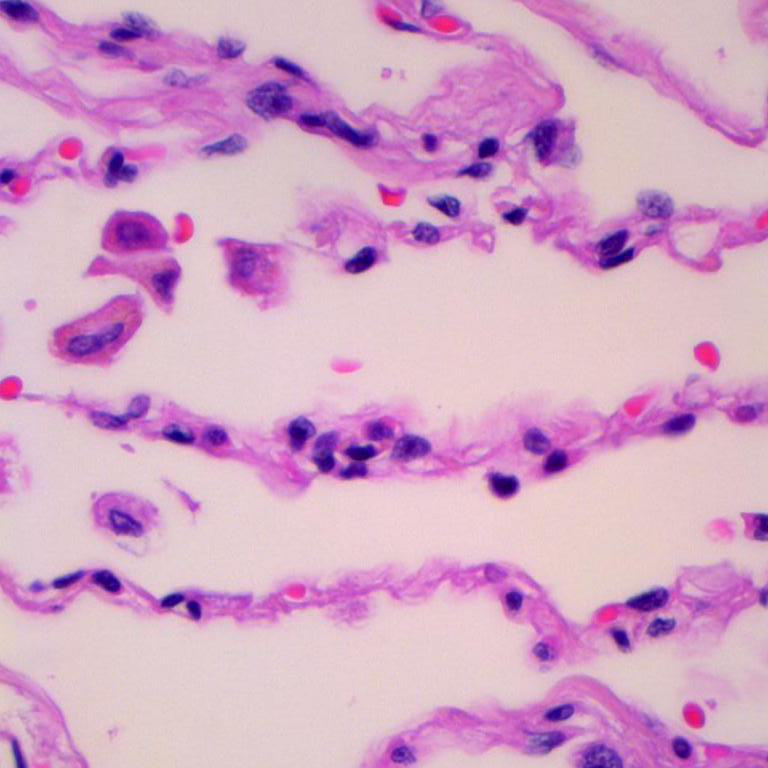

In [52]:
data_dir = 'D:/image_processing/Lung'
sample_img = os.path.join(data_dir, 'after_split/train/Benign/Benign_original_lungn1.jpeg_b5c46125-27fb-4ebc-8978-6570645e715a.jpeg')
img = Image.open(sample_img)
img

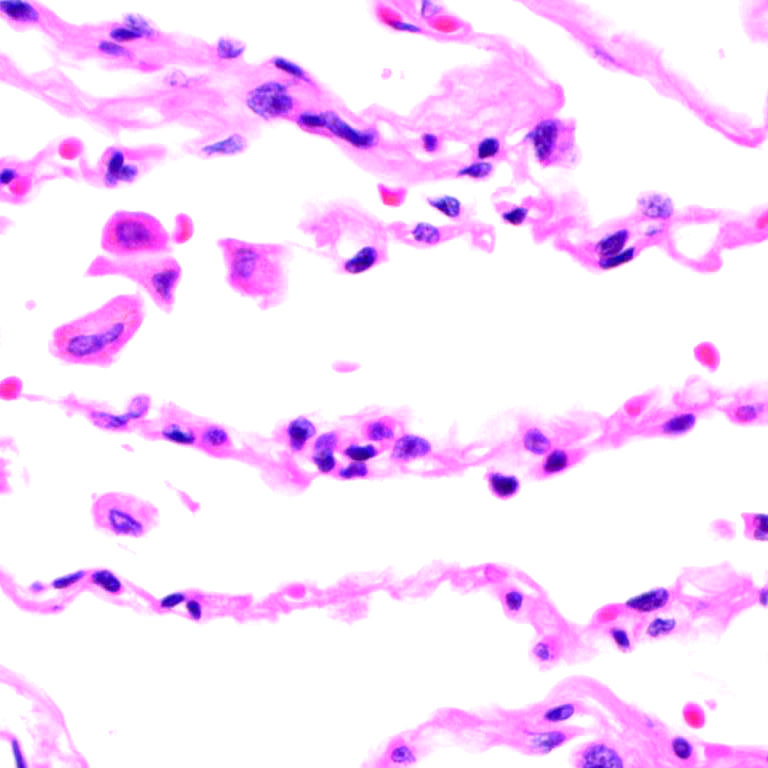

In [57]:
curr_bri = ImageEnhance.Brightness(img)
new_bri = 1.5
  
img_brightened = curr_bri.enhance(new_bri)
  
img_brightened

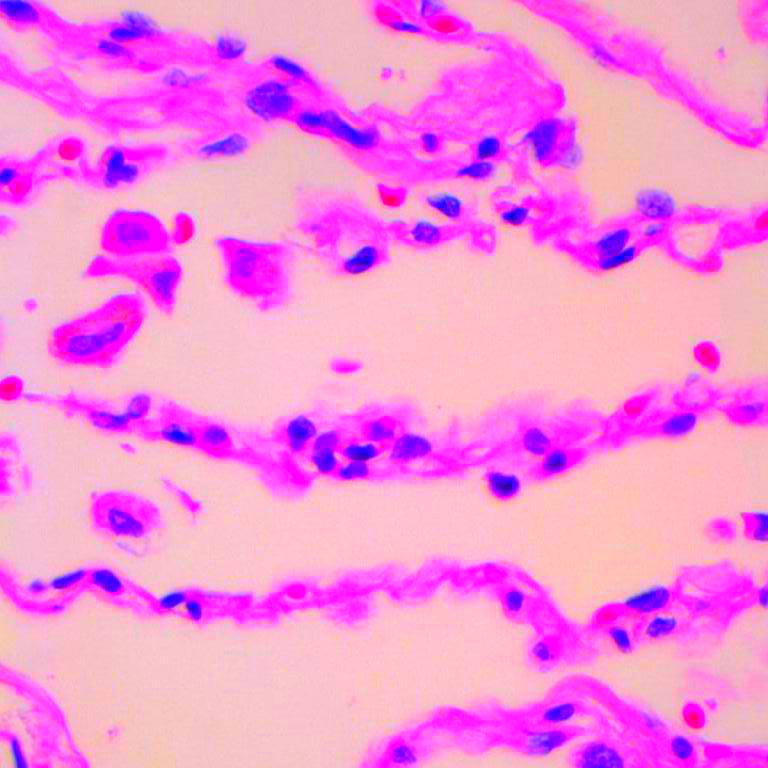

In [58]:
curr_col = ImageEnhance.Color(img)
new_col = 2.5
  
img_colored = curr_col.enhance(new_col)
  
img_colored

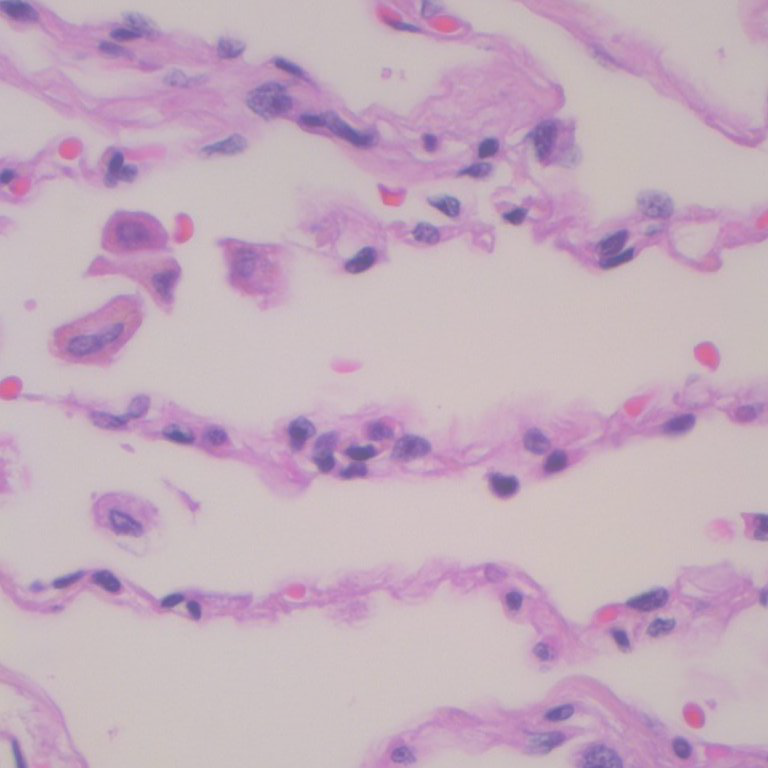

In [64]:
curr_con = ImageEnhance.Contrast(img)
new_con = 0.5
  
img_contrasted = curr_con.enhance(new_con)
  
img_contrasted

In [67]:
p_test = Augmentor.Pipeline("D:/image_processing/Lung/after_split/test")

Initialised with 1500 image(s) found.
Output directory set to D:/image_processing/Lung/after_split/test\output.

In [68]:
p_test.random_brightness(probability=0.5, min_factor=0.9, max_factor=1.6)
p_test.random_color(probability=0.5, min_factor=0.9, max_factor=1.6)
p_test.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.6)
p_test.histogram_equalisation(probability=1)
p_test.process()

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x220723EAD00>: 100%|██████████| 1500/1500 [00:19<00:00, 77.35 Samples/s] 


In [70]:
new_test_dir = os.path.join(base_dir, 'test/new_test')
new_test_data = tf.keras.utils.image_dataset_from_directory(directory = new_test_dir,
                                                           labels = 'inferred',
                                                           batch_size=batch_size,
                                                           label_mode='categorical',
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')
new_test = new_test_data.map(map_fn)

Found 1500 files belonging to 3 classes.


In [71]:
loss, accuracy_d = model_inceptionres.evaluate(new_test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

94/94 - 25s - loss: 0.8909 - accuracy: 0.7493 - 25s/epoch - 267ms/step
 model, accuracy: 74.93%


#### The model accuracy dropped from 97.93% to 74.93%

## Re-training the model on enhanced images 

In [72]:
p_train = Augmentor.Pipeline("D:/image_processing/Lung/after_split/train")
p_val = Augmentor.Pipeline("D:/image_processing/Lung/after_split/val")

Initialised with 21000 image(s) found.
Output directory set to D:/image_processing/Lung/after_split/train\output.Initialised with 6000 image(s) found.
Output directory set to D:/image_processing/Lung/after_split/val\output.

In [73]:
p_train.random_brightness(probability=0.5, min_factor=0.9, max_factor=1.6)
p_train.random_color(probability=0.5, min_factor=0.9, max_factor=1.6)
p_train.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.6)
p_train.histogram_equalisation(probability=1)
p_train.process()

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x221DAC073A0>: 100%|██████████| 21000/21000 [04:53<00:00, 71.52 Samples/s] 


In [74]:
p_val.random_brightness(probability=0.5, min_factor=0.9, max_factor=1.6)
p_val.random_color(probability=0.5, min_factor=0.9, max_factor=1.6)
p_val.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.6)
p_val.histogram_equalisation(probability=1)
p_val.process()

Processing <PIL.Image.Image image mode=RGB size=768x768 at 0x221C27D3F10>: 100%|██████████| 6000/6000 [01:26<00:00, 68.97 Samples/s] 


In [75]:
batch_size = 16
IMG_SHAPE = 299
base_dir = 'D:/image_processing/Lung/after_split'

new_train_dir = os.path.join(base_dir, 'train/new_train')
new_val_dir = os.path.join(base_dir, 'val/new_val')


In [76]:
new_training_data = tf.keras.utils.image_dataset_from_directory(directory = new_train_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           shuffle=True,
                                                           color_mode='rgb')

new_val_data = tf.keras.utils.image_dataset_from_directory(directory = new_val_dir,
                                                           labels = 'inferred',
                                                           label_mode='categorical',
                                                           batch_size=batch_size,
                                                           image_size=(IMG_SHAPE, IMG_SHAPE),
                                                           color_mode='rgb')

Found 21000 files belonging to 3 classes.
Found 6000 files belonging to 3 classes.


In [77]:
new_trian = new_training_data.map(map_fn)
new_val = new_val_data.map(map_fn)

In [78]:
URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
  trainable=False)

with tf.device(device_name=device):
    
    new_model = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(3)
    ])

    new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dense_1 (Dense)             (None, 3)                 4611      
                                                                 
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
_________________________________________________________________


In [79]:
with tf.device(device_name=device):
    
    new_model.compile(
      optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
      momentum=0.9),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

In [80]:
EPOCHS = 10
with tf.device(device_name=device):
    
    history = new_model.fit(new_trian,
                        epochs=EPOCHS,
                        validation_data=new_val)

Epoch 1/10
1313/1313 [==============================] - 499s 371ms/step - loss: 0.3100 - accuracy: 0.8878 - val_loss: 0.5145 - val_accuracy: 0.8313
Epoch 2/10
1313/1313 [==============================] - 494s 376ms/step - loss: 0.2290 - accuracy: 0.9179 - val_loss: 0.2516 - val_accuracy: 0.9070
Epoch 3/10
1313/1313 [==============================] - 546s 415ms/step - loss: 0.2063 - accuracy: 0.9232 - val_loss: 0.2084 - val_accuracy: 0.9173
Epoch 4/10
1313/1313 [==============================] - 518s 394ms/step - loss: 0.1900 - accuracy: 0.9287 - val_loss: 0.1830 - val_accuracy: 0.9323
Epoch 5/10
1313/1313 [==============================] - 490s 373ms/step - loss: 0.1834 - accuracy: 0.9331 - val_loss: 0.1651 - val_accuracy: 0.9397
Epoch 6/10
1313/1313 [==============================] - 489s 373ms/step - loss: 0.1822 - accuracy: 0.9341 - val_loss: 0.2171 - val_accuracy: 0.9243
Epoch 7/10
1313/1313 [==============================] - 488s 371ms/step - loss: 0.1667 - accuracy: 0.9381 - val_

#### Testing on the enhanced images

In [81]:
loss, accuracy_d = new_model.evaluate(new_test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

94/94 - 26s - loss: 0.1144 - accuracy: 0.9560 - 26s/epoch - 277ms/step
 model, accuracy: 95.60%


#### Testing on the old images

In [82]:
loss, accuracy_d = new_model.evaluate(test, verbose=2)
print(" model, accuracy: {:5.2f}%".format(100 * accuracy_d))

94/94 - 27s - loss: 0.1474 - accuracy: 0.9447 - 27s/epoch - 290ms/step
 model, accuracy: 94.47%


In [83]:
new_model.save('D:/image_processing/Lung/model_with_enhance.h5')

### Enhancing images decreased the accuracy, but histogram equalisation filter made the model generalize moderately well on the old test images.
>Old Test split with accuracy 94.47% only dropped 3.46%. Without the filter, the model would perform much worse.